In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from gpytorch import ExactMarginalLogLikelihood
from torch.utils.data import DataLoader, TensorDataset
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.priors import GammaPrior
from botorch.models import SingleTaskVariationalGP
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'lines.markersize': 8})

In [2]:
# Generate sinusoidal training data
n_train = 150
n_test = 50

x_train = torch.linspace(0, 4 * torch.pi, n_train, dtype=torch.double).unsqueeze(1)
y_train = torch.sin(x_train) + 0.1 * torch.randn(n_train, 1)

x_test = torch.linspace(0, 4 * torch.pi, n_test, dtype=torch.double).unsqueeze(1)
y_test = torch.sin(x_test) + 0.1 * torch.randn(n_test, 1)

# Move data to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

print(x_train.shape)
print(y_train.shape)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

torch.Size([150, 1])
torch.Size([150, 1])


In [3]:
from gp.deepgplayers import DeepGPMultivariateNormal
import matplotlib.pyplot as plt

# Warning: does depend on global variables
def predict_and_plot_deep_gp(model, train_loader, test_loader, save_path=None, dpi=300):
    def split_array(arr):
        arr_less_than_zero = arr[arr <= 0]
        arr_greater_than_zero = arr[arr > 0]
        return arr_less_than_zero, arr_greater_than_zero
    
    # Predict on train data
    train_means = torch.tensor([0.])
    train_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            preds = model.posterior(x_batch, observation_noise=False)
            for pred in preds.mean:
                train_means = torch.cat([train_means, pred.cpu()])
            for vars in preds.variance:
                train_variances = torch.cat([train_variances, vars.cpu()])
    train_means = train_means[1:]
    train_variances = train_variances[1:]

    # Predict on test data
    test_means = torch.tensor([0.])
    test_variances = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model.posterior(x_batch, observation_noise=False)
            for pred in preds.mean:
                test_means = torch.cat([test_means, pred.cpu()])
            for vars in preds.variance:
                test_variances = torch.cat([test_variances, vars.cpu()])
    test_means = test_means[1:]
    test_variances = test_variances[1:]

    # Compute the Mean Squared Error (MSE) for test data
    print('Train MAE: {}'.format(torch.mean(torch.abs(train_means - y_train.cpu()))))
    print('Test MAE: {}'.format(torch.mean(torch.abs(test_means - y_test.cpu()))))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'k*', label='Training Data')
    # plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), 'r*', label='Testing Data')
    
    plt.plot(x_train.cpu().numpy(), train_means.cpu().numpy(), 'b', label='Train predictions')
    
    """
    less, more = split_array(x_test.squeeze().cpu().numpy())
    plt.plot(less, test_means[0:len(less)].cpu().numpy(), 'r', label='Test predictions')
    plt.plot(more, test_means[len(less):].cpu().numpy(), 'r', label='Test predictions')
    """

    # Plot training variance as a shaded area
    plt.fill_between(x_train.squeeze().cpu().numpy(),
                     train_means.cpu().numpy() - 2 * train_variances.cpu().numpy() ** 0.5,
                     train_means.cpu().numpy() + 2 * train_variances.cpu().numpy() ** 0.5,
                     color='b', alpha=0.2, label='Train predictive variance')

    
    """
    
    # Plot test variance as a shaded area
    plt.fill_between(less,
                     test_means[0:len(less)].cpu().numpy() - 2 * test_variances[0:len(less)].cpu().numpy() ** 0.5,
                     test_means[0:len(less)].cpu().numpy() + 2 * test_variances[0:len(less)].cpu().numpy() ** 0.5,
                     color='r', alpha=0.2, label='Test predictive variance')
    plt.fill_between(more,
                     test_means[len(less):].cpu().numpy() - 2 * test_variances[len(less):].cpu().numpy() ** 0.5,
                     test_means[len(less):].cpu().numpy() + 2 * test_variances[len(less):].cpu().numpy() ** 0.5,
                     color='r', alpha=0.2, label='Test predictive variance')
    """
    plt.legend()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

def predict_and_plot_deep_gp_layers(model, x_train, y_train, x_test, y_test):
    def split_array(arr):
        arr_less_than_zero = arr[arr < 0]
        arr_greater_than_zero = arr[arr > 0]
        return arr_less_than_zero, arr_greater_than_zero
    
    model.eval()
    model.likelihood.eval()
    
    with torch.no_grad():
        model(x_train)
        intermediate_outputs = model.get_intermediate_outputs()
        
    with torch.no_grad():
        model(x_test)
        intermediate_outputs_test = model.get_intermediate_outputs()

    num_layers = len(intermediate_outputs)
    
    plt.figure(figsize=(12, 6 * num_layers))
    
    less, more = split_array(x_test.squeeze().cpu().numpy())
    
    for i, layer_output in enumerate(intermediate_outputs, 1):
        layer_output = DeepGPMultivariateNormal(distribution=layer_output)
        
        # print(layer_output.mean.squeeze(1).shape)
        layer_mean = layer_output.mean.squeeze(1).cpu().numpy()
        layer_var = layer_output.variance.squeeze(1).cpu().numpy()
        
        plt.subplot(num_layers, 1, i)
        plt.plot(x_train.cpu().numpy(), y_train.cpu().numpy(), 'k*', label='Train')
        plt.plot(x_train.cpu().numpy(), layer_mean, 'b', label=f'Layer {i} Mean')
        plt.fill_between(
            x_train.cpu().numpy().squeeze(),
            layer_mean - 2 * layer_var ** 0.5,
            layer_mean + 2 * layer_var ** 0.5,
            color='b', alpha=0.2, label=f'Layer {i} Variance'
        )
        
        plt.title(f'Predictions of Layer {i}')
        plt.legend()
        
    for i, layer_output in enumerate(intermediate_outputs_test, 1):
        layer_output = DeepGPMultivariateNormal(distribution=layer_output)
        
        layer_mean_test = layer_output.mean.squeeze(1).cpu().numpy()
        layer_var_test = layer_output.variance.squeeze(1).cpu().numpy()
        
        plt.subplot(num_layers, 1, i)
        plt.plot(less, y_test[0:len(less)].cpu().numpy(), 'r*', label='Test')
        plt.plot(more, y_test[len(less):].cpu().numpy(), 'r*', label='Test')
        plt.plot(less, layer_mean_test[0:len(less)], 'r', label=f'Layer {i} Mean')
        plt.plot(more, layer_mean_test[len(less):], 'r', label=f'Layer {i} Mean')
        
                # Plot test variance as a shaded area
        plt.fill_between(less,
                         layer_mean_test[0:len(less)] - 2 * layer_var_test[0:len(less)] ** 0.5,
                         layer_mean_test[0:len(less)] + 2 * layer_var_test[0:len(less)] ** 0.5,
                         color='r', alpha=0.2, label='Test predictive variance')
        plt.fill_between(more,
                         layer_mean_test[len(less):] - 2 * layer_var_test[len(less):] ** 0.5,
                         layer_mean_test[len(less):] + 2 * layer_var_test[len(less):] ** 0.5,
                         color='r', alpha=0.2, label='Test predictive variance')

    plt.show()
    plt.savefig("Y", dpi=300)


In [6]:
from gpytorch.mlls import DeepApproximateMLL
from gp.deepgp import DeepGPModel

# Define the deep GP model
deep_gp = DeepGPModel(
    train_x_shape=x_train.shape,
    hidden_layers_config=[
        {"output_dims": 1, "mean_type": "linear"},
        {"output_dims": 1, "mean_type": "linear"},
        {"output_dims": 1, "mean_type": "linear"},
        {"output_dims": None, "mean_type": "constant"}
    ],
    num_inducing_points=128
)
deep_gp = deep_gp.to(device)

# Training settings
deep_gp.train()
deep_gp.likelihood.train()

optimizer = torch.optim.Adam(deep_gp.parameters(), lr=0.01)
mll = DeepApproximateMLL(gpytorch.mlls.VariationalELBO(deep_gp.likelihood, deep_gp, y_train.numel()))

y_train_ = y_train.squeeze(1)

# Training loop
training_iterations = 300
for i in range(training_iterations):
    with gpytorch.settings.num_likelihood_samples(30):
        optimizer.zero_grad()
        output = deep_gp(x_train)
        loss = -mll(output, y_train_)
        loss.backward()
        optimizer.step()
    if (i + 1) % 100 == 0:
        print(f'Iteration {i + 1}/{training_iterations} - Loss: {loss.item()}')
        
        


Iteration 100/500 - Loss: 0.8394051264469923
Iteration 200/500 - Loss: 0.3767411841136971
Iteration 300/500 - Loss: -0.06297568592455927
Iteration 400/500 - Loss: -0.30882535174141096
Iteration 500/500 - Loss: -0.4448591639845065


Train MAE: 0.8183343007307634
Test MAE: 0.8050642999171067


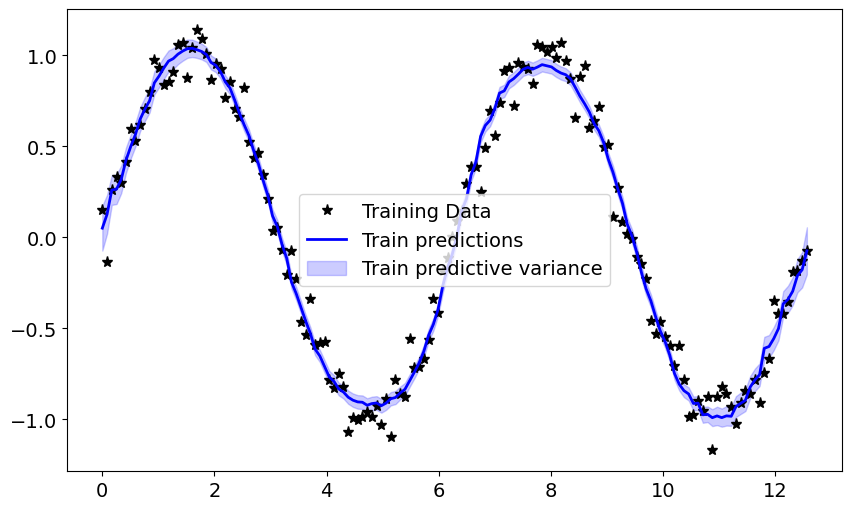

In [7]:
predict_and_plot_deep_gp(deep_gp, train_loader, test_loader, save_path="deep_gp")